In [1]:
# 01_persistence_forecast.py
# example of a one-step naive forecast
def naive_forecast(history, n):
	return history[-n]

# define dataset
data = [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
print(data)
# test naive forecast
for i in range(1, len(data)+1):
	print(naive_forecast(data, i))

[10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
100.0
90.0
80.0
70.0
60.0
50.0
40.0
30.0
20.0
10.0


In [3]:
# 02_average_forecast.py
# example of an average forecast
from numpy import mean
from numpy import median

# one-step average forecast
def average_forecast(history, config):
	n, avg_type = config
	# mean of last n values
	if avg_type == 'mean':
		return mean(history[-n:])
	# median of last n values
	return median(history[-n:])

# define dataset
data = [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
print(data)
# test naive forecast
for i in range(1, len(data)+1):
	print(average_forecast(data, (i, 'mean')))

[10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
100.0
95.0
90.0
85.0
80.0
75.0
70.0
65.0
60.0
55.0


In [4]:
# 03_average_forecast_seasonality.py
# example of an average forecast for seasonal data
from numpy import mean
from numpy import median

# one-step average forecast
def average_forecast(history, config):
	n, offset, avg_type = config
	values = list()
	if offset == 1:
		values = history[-n:]
	else:
		# skip bad configs
		if n*offset > len(history):
			raise Exception('Config beyond end of data: %d %d' % (n,offset))
		# try and collect n values using offset
		for i in range(1, n+1):
			ix = i * offset
			values.append(history[-ix])
	# mean of last n values
	if avg_type == 'mean':
		return mean(values)
	# median of last n values
	return median(values)

# define dataset
data = [10.0, 20.0, 30.0, 10.0, 20.0, 30.0, 10.0, 20.0, 30.0]
print(data)
# test naive forecast
for i in [1, 2, 3]:
	print(average_forecast(data, (i, 3, 'mean')))

[10.0, 20.0, 30.0, 10.0, 20.0, 30.0, 10.0, 20.0, 30.0]
10.0
10.0
10.0


In [5]:
# 04_grid_search.py
# grid search simple forecasts
from math import sqrt
from numpy import mean
from numpy import median
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error

# one-step simple forecast
def simple_forecast(history, config):
	n, offset, avg_type = config
	# persist value, ignore other config
	if avg_type == 'persist':
		return history[-n]
	# collect values to average
	values = list()
	if offset == 1:
		values = history[-n:]
	else:
		# skip bad configs
		if n*offset > len(history):
			raise Exception('Config beyond end of data: %d %d' % (n,offset))
		# try and collect n values using offset
		for i in range(1, n+1):
			ix = i * offset
			values.append(history[-ix])
	# check if we can average
	if len(values) < 2:
		raise Exception('Cannot calculate average')
	# mean of last n values
	if avg_type == 'mean':
		return mean(values)
	# median of last n values
	return median(values)

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = simple_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of simple configs to try
def simple_configs(max_length, offsets=[1]):
	configs = list()
	for i in range(1, max_length+1):
		for o in offsets:
			for t in ['persist', 'mean', 'median']:
				cfg = [i, o, t]
				configs.append(cfg)
	return configs

__name__ = '__main__'
if __name__ == '__main__':
	# define dataset
	data = [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
	# data split
	n_test = 4
	# model configs
	max_length = len(data) - n_test
	cfg_list = simple_configs(max_length)
	# grid search
	scores = grid_search(data, cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error in scores[:3]:
		print(cfg, error)

 > Model[[1, 1, 'persist']] 10.000 > Model[[2, 1, 'persist']] 20.000

 > Model[[3, 1, 'persist']] 30.000 > Model[[2, 1, 'mean']] 15.000

 > Model[[3, 1, 'mean']] 20.000
 > Model[[3, 1, 'median']] 20.000
 > Model[[4, 1, 'persist']] 40.000 > Model[[2, 1, 'median']] 15.000

 > Model[[4, 1, 'mean']] 25.000 > Model[[5, 1, 'persist']] 50.000

 > Model[[4, 1, 'median']] 25.000
 > Model[[5, 1, 'mean']] 30.000 > Model[[5, 1, 'median']] 30.000
 > Model[[6, 1, 'persist']] 60.000

 > Model[[6, 1, 'mean']] 35.000
 > Model[[6, 1, 'median']] 35.000
done
[1, 1, 'persist'] 10.0
[2, 1, 'mean'] 15.0
[2, 1, 'median'] 15.0


(365, 1)


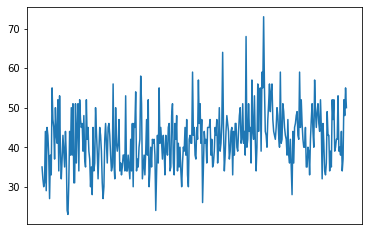

In [7]:
# 05_load_plot_daily_births.py
# load and plot daily births dataset
from pandas import read_csv
from matplotlib import pyplot
# load
series = read_csv('daily-total-female-births.csv', header=0, index_col=0)
# summarize shape
print(series.shape)
# plot
pyplot.plot(series)
pyplot.xticks([])
pyplot.show()

In [8]:
# 06_grid_search_daily_births.py
# grid search simple forecast for daily female births
from math import sqrt
from numpy import mean
from numpy import median
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error
from pandas import read_csv

# one-step simple forecast
def simple_forecast(history, config):
	n, offset, avg_type = config
	# persist value, ignore other config
	if avg_type == 'persist':
		return history[-n]
	# collect values to average
	values = list()
	if offset == 1:
		values = history[-n:]
	else:
		# skip bad configs
		if n*offset > len(history):
			raise Exception('Config beyond end of data: %d %d' % (n,offset))
		# try and collect n values using offset
		for i in range(1, n+1):
			ix = i * offset
			values.append(history[-ix])
	# check if we can average
	if len(values) < 2:
		raise Exception('Cannot calculate average')
	# mean of last n values
	if avg_type == 'mean':
		return mean(values)
	# median of last n values
	return median(values)

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = simple_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of simple configs to try
def simple_configs(max_length, offsets=[1]):
	configs = list()
	for i in range(1, max_length+1):
		for o in offsets:
			for t in ['persist', 'mean', 'median']:
				cfg = [i, o, t]
				configs.append(cfg)
	return configs

if __name__ == '__main__':
	# define dataset
	series = read_csv('daily-total-female-births.csv', header=0, index_col=0)
	data = series.values
	# data split
	n_test = 165
	# model configs
	max_length = len(data) - n_test
	cfg_list = simple_configs(max_length)
	# grid search
	scores = grid_search(data, cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error in scores[:3]:
		print(cfg, error)

 > Model[[1, 1, 'persist']] 8.722
 > Model[[2, 1, 'persist']] 9.284 > Model[[2, 1, 'mean']] 7.884

 > Model[[3, 1, 'persist']] 9.320
 > Model[[3, 1, 'mean']] 7.518
 > Model[[2, 1, 'median']] 7.884 > Model[[3, 1, 'median']] 7.324

 > Model[[4, 1, 'persist']] 9.249 > Model[[4, 1, 'mean']] 7.290

 > Model[[4, 1, 'median']] 7.217
 > Model[[5, 1, 'persist']] 9.415
 > Model[[6, 1, 'mean']] 7.222 > Model[[5, 1, 'mean']] 7.204

 > Model[[6, 1, 'median']] 7.230 > Model[[5, 1, 'median']] 7.337
 > Model[[7, 1, 'persist']] 8.791

 > Model[[6, 1, 'persist']] 9.737
 > Model[[7, 1, 'mean']] 7.042
 > Model[[9, 1, 'persist']] 10.175
 > Model[[7, 1, 'median']] 7.340 > Model[[9, 1, 'mean']] 7.200

 > Model[[8, 1, 'persist']] 10.172
 > Model[[8, 1, 'mean']] 7.140
 > Model[[9, 1, 'median']] 7.302
 > Model[[10, 1, 'persist']] 9.956
 > Model[[8, 1, 'median']] 7.331
 > Model[[13, 1, 'persist']] 10.020
 > Model[[10, 1, 'mean']] 7.209
 > Model[[13, 1, 'mean']] 7.238
 > Model[[10, 1, 'median']] 7.349 > Model[[13

In [9]:
# 08_grid_search_shampoo_sales.py
# grid search simple forecast for monthly shampoo sales
from math import sqrt
from numpy import mean
from numpy import median
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error
from pandas import read_csv

# one-step simple forecast
def simple_forecast(history, config):
	n, offset, avg_type = config
	# persist value, ignore other config
	if avg_type == 'persist':
		return history[-n]
	# collect values to average
	values = list()
	if offset == 1:
		values = history[-n:]
	else:
		# skip bad configs
		if n*offset > len(history):
			raise Exception('Config beyond end of data: %d %d' % (n,offset))
		# try and collect n values using offset
		for i in range(1, n+1):
			ix = i * offset
			values.append(history[-ix])
	# check if we can average
	if len(values) < 2:
		raise Exception('Cannot calculate average')
	# mean of last n values
	if avg_type == 'mean':
		return mean(values)
	# median of last n values
	return median(values)

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = simple_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of simple configs to try
def simple_configs(max_length, offsets=[1]):
	configs = list()
	for i in range(1, max_length+1):
		for o in offsets:
			for t in ['persist', 'mean', 'median']:
				cfg = [i, o, t]
				configs.append(cfg)
	return configs

if __name__ == '__main__':
	# load dataset
	series = read_csv('monthly-shampoo-sales.csv', header=0, index_col=0)
	data = series.values
	# data split
	n_test = 12
	# model configs
	max_length = len(data) - n_test
	cfg_list = simple_configs(max_length)
	# grid search
	scores = grid_search(data, cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error in scores[:3]:
		print(cfg, error)

 > Model[[1, 1, 'persist']] 136.761
 > Model[[2, 1, 'persist']] 95.695
 > Model[[3, 1, 'persist']] 123.969 > Model[[2, 1, 'mean']] 96.011

 > Model[[3, 1, 'mean']] 96.403
 > Model[[2, 1, 'median']] 96.011 > Model[[3, 1, 'median']] 103.634
 > Model[[4, 1, 'persist']] 136.813
 > Model[[4, 1, 'mean']] 100.609

 > Model[[5, 1, 'persist']] 127.656 > Model[[4, 1, 'median']] 104.878

 > Model[[6, 1, 'mean']] 110.425 > Model[[5, 1, 'mean']] 101.862

 > Model[[6, 1, 'median']] 114.959
 > Model[[5, 1, 'median']] 101.819 > Model[[7, 1, 'persist']] 164.514

 > Model[[7, 1, 'mean']] 115.500
 > Model[[6, 1, 'persist']] 165.500 > Model[[7, 1, 'median']] 124.605

 > Model[[9, 1, 'persist']] 193.951 > Model[[8, 1, 'persist']] 186.545
 > Model[[8, 1, 'mean']] 122.807

 > Model[[9, 1, 'mean']] 128.902 > Model[[8, 1, 'median']] 132.409

 > Model[[9, 1, 'median']] 136.633
 > Model[[10, 1, 'mean']] 135.664 > Model[[10, 1, 'persist']] 205.511

 > Model[[10, 1, 'median']] 142.336
 > Model[[13, 1, 'persist']] 

(240, 1)


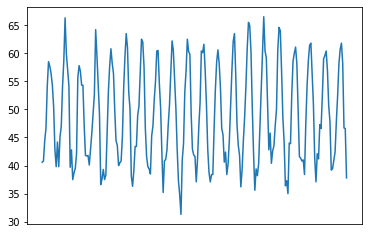

In [10]:
# 09_load_plot_monthly_mean_temp.py
# load and plot monthly mean temp dataset
from pandas import read_csv
from matplotlib import pyplot
# load
series = read_csv('monthly-mean-temp.csv', header=0, index_col=0)
# summarize shape
print(series.shape)
# plot
pyplot.plot(series)
pyplot.xticks([])
pyplot.show()

In [11]:
# 10_grid_search_mean_temp.py
# grid search simple forecast for monthly mean temperature
from math import sqrt
from numpy import mean
from numpy import median
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error
from pandas import read_csv

# one-step simple forecast
def simple_forecast(history, config):
	n, offset, avg_type = config
	# persist value, ignore other config
	if avg_type == 'persist':
		return history[-n]
	# collect values to average
	values = list()
	if offset == 1:
		values = history[-n:]
	else:
		# skip bad configs
		if n*offset > len(history):
			raise Exception('Config beyond end of data: %d %d' % (n,offset))
		# try and collect n values using offset
		for i in range(1, n+1):
			ix = i * offset
			values.append(history[-ix])
	# check if we can average
	if len(values) < 2:
		raise Exception('Cannot calculate average')
	# mean of last n values
	if avg_type == 'mean':
		return mean(values)
	# median of last n values
	return median(values)

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = simple_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of simple configs to try
def simple_configs(max_length, offsets=[1]):
	configs = list()
	for i in range(1, max_length+1):
		for o in offsets:
			for t in ['persist', 'mean', 'median']:
				cfg = [i, o, t]
				configs.append(cfg)
	return configs

if __name__ == '__main__':
	# define dataset
	series = read_csv('monthly-mean-temp.csv', header=0, index_col=0)
	data = series.values
	# data split
	n_test = 12
	# model configs
	max_length = len(data) - n_test
	cfg_list = simple_configs(max_length, offsets=[1,12])
	# grid search
	scores = grid_search(data, cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error in scores[:3]:
		print(cfg, error)

 > Model[[1, 12, 'persist']] 5.143 > Model[[1, 1, 'persist']] 5.143
 > Model[[2, 1, 'persist']] 8.492

 > Model[[2, 1, 'median']] 6.538 > Model[[2, 1, 'mean']] 6.538

 > Model[[2, 12, 'persist']] 8.492 > Model[[2, 12, 'mean']] 1.589
 > Model[[3, 1, 'persist']] 12.006

 > Model[[3, 1, 'mean']] 8.155 > Model[[2, 12, 'median']] 1.589

 > Model[[3, 1, 'median']] 8.331 > Model[[3, 12, 'mean']] 1.714
 > Model[[3, 12, 'persist']] 12.006
 > Model[[3, 12, 'median']] 2.078

 > Model[[4, 1, 'median']] 9.787 > Model[[4, 1, 'persist']] 14.252

 > Model[[4, 1, 'mean']] 9.442
 > Model[[5, 1, 'persist']] 15.418 > Model[[4, 12, 'persist']] 14.252

 > Model[[4, 12, 'mean']] 1.502 > Model[[5, 1, 'mean']] 10.311

 > Model[[5, 1, 'median']] 11.323
 > Model[[5, 12, 'persist']] 15.418
 > Model[[5, 12, 'mean']] 1.719
 > Model[[4, 12, 'median']] 1.643 > Model[[5, 12, 'median']] 1.801

 > Model[[6, 1, 'persist']] 15.725 > Model[[7, 1, 'persist']] 15.127
 > Model[[6, 1, 'mean']] 10.813
 > Model[[7, 1, 'mean']] 1

(108, 1)


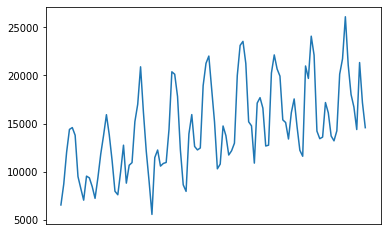

In [12]:
# 11_load_plot_monthly_car_sales.py
# load and plot monthly car sales dataset
from pandas import read_csv
from matplotlib import pyplot
# load
series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
# summarize shape
print(series.shape)
# plot
pyplot.plot(series)
pyplot.xticks([])
pyplot.show()

In [13]:
# 12_grid_search_car_sales.py
# grid search simple forecast for monthly car sales
from math import sqrt
from numpy import mean
from numpy import median
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error
from pandas import read_csv

# one-step simple forecast
def simple_forecast(history, config):
	n, offset, avg_type = config
	# persist value, ignore other config
	if avg_type == 'persist':
		return history[-n]
	# collect values to average
	values = list()
	if offset == 1:
		values = history[-n:]
	else:
		# skip bad configs
		if n*offset > len(history):
			raise Exception('Config beyond end of data: %d %d' % (n,offset))
		# try and collect n values using offset
		for i in range(1, n+1):
			ix = i * offset
			values.append(history[-ix])
	# check if we can average
	if len(values) < 2:
		raise Exception('Cannot calculate average')
	# mean of last n values
	if avg_type == 'mean':
		return mean(values)
	# median of last n values
	return median(values)

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = simple_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of simple configs to try
def simple_configs(max_length, offsets=[1]):
	configs = list()
	for i in range(1, max_length+1):
		for o in offsets:
			for t in ['persist', 'mean', 'median']:
				cfg = [i, o, t]
				configs.append(cfg)
	return configs

if __name__ == '__main__':
	# define dataset
	series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
	data = series.values
	# data split
	n_test = 12
	# model configs
	max_length = len(data) - n_test
	cfg_list = simple_configs(max_length, offsets=[1,12])
	# grid search
	scores = grid_search(data, cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error in scores[:3]:
		print(cfg, error)

 > Model[[1, 1, 'persist']] 3783.966 > Model[[1, 12, 'persist']] 3783.966

 > Model[[2, 1, 'persist']] 5171.658
 > Model[[2, 1, 'median']] 4119.852
 > Model[[2, 12, 'persist']] 5171.658 > Model[[2, 1, 'mean']] 4119.852

 > Model[[3, 1, 'persist']] 6000.907 > Model[[2, 12, 'mean']] 2215.186
 > Model[[3, 1, 'mean']] 4474.174

 > Model[[2, 12, 'median']] 2215.186 > Model[[3, 1, 'median']] 4243.965

 > Model[[3, 12, 'mean']] 2115.198 > Model[[3, 12, 'persist']] 6000.907

 > Model[[4, 1, 'median']] 4672.775
 > Model[[4, 12, 'persist']] 6285.170
 > Model[[4, 12, 'mean']] 2385.125
 > Model[[4, 12, 'median']] 2184.377
 > Model[[5, 1, 'persist']] 5668.407
 > Model[[5, 1, 'mean']] 4535.757
 > Model[[3, 12, 'median']] 1841.156
 > Model[[4, 1, 'persist']] 6285.170
 > Model[[4, 1, 'mean']] 4646.905
 > Model[[5, 1, 'median']] 5196.987 > Model[[5, 12, 'mean']] 2843.253

 > Model[[5, 12, 'median']] 2621.677 > Model[[5, 12, 'persist']] 5668.407
 > Model[[6, 1, 'persist']] 5798.153
 > Model[[6, 1, 'mean